In [1]:
from google.colab import drive
drive.mount('/content/drive')
rootPath = '/content/drive/My Drive/DL_CV_FinalProject/'
dataPath = '/content/data/'


Mounted at /content/drive


In [2]:
!chmod 755 '/content/drive/My Drive/DL_CV_FinalProject/helpfulColabScripts/getURFD.sh'
!'/content/drive/My Drive/DL_CV_FinalProject/helpfulColabScripts/getURFD.sh'

--2020-12-05 08:39:00--  http://fenix.univ.rzeszow.pl/~mkepski/ds/data/fall-01-cam0-rgb.zip
Resolving fenix.univ.rzeszow.pl (fenix.univ.rzeszow.pl)... 62.93.43.105
Connecting to fenix.univ.rzeszow.pl (fenix.univ.rzeszow.pl)|62.93.43.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57727213 (55M) [application/zip]
Saving to: ‘fall-01-cam0-rgb.zip’

fall-01-cam0-rgb.zi 100%[===================>]  55.05M  16.2MB/s    in 4.5s    

2020-12-05 08:39:05 (12.3 MB/s) - ‘fall-01-cam0-rgb.zip’ saved [57727213/57727213]

--2020-12-05 08:39:05--  http://fenix.univ.rzeszow.pl/~mkepski/ds/data/fall-02-cam0-rgb.zip
Resolving fenix.univ.rzeszow.pl (fenix.univ.rzeszow.pl)... 62.93.43.105
Connecting to fenix.univ.rzeszow.pl (fenix.univ.rzeszow.pl)|62.93.43.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41132305 (39M) [application/zip]
Saving to: ‘fall-02-cam0-rgb.zip’

fall-02-cam0-rgb.zi 100%[===================>]  39.23M  11.8MB/s    in 3.5s    

In [3]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

     |████████████████████████████████| 276kB 9.0MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=47f969ae00ded4a1bb0e6aa95b2c2e4b7d89d627df4ef0c1e6f638a7f5dfe949
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 6.9MB/s 
     |████████████████████████████████| 2.2MB 9.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201204-cp36-none-an

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
#from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import sys
import time
import pickle
import glob
import matplotlib.pyplot as plt
import tqdm
import pandas as pd 
import glob

In [5]:
## Check for GPU 
gpu_check = torch.cuda.is_available()
print(gpu_check)

urdfDataset = sorted(glob.glob(dataPath + '*/'))

True


In [6]:
## Initialize class for predictor functions
class ReturnPredictions(object):
    def __init__(self,cfg):
        self.predictor = DefaultPredictor(cfg)
        self.metadata = MetadataCatalog.get(
                cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused")

    def _frame_from_video(self,video):
        print(video)
        while video.isOpened():
            success,frame = video.read()
            if success:
                yield frame
            else:
                break

    def run_on_video(self,video):
        frame_gen = self._frame_from_video(video)
        for frame in frame_gen:
            
            yield self.predictor(frame),frame

    def run_on_image(self,image):
      # Convert image from OpenCV BGR format to Matplotlib RGB format.
      yield self.predictor(image),image


## Load and setup model and predictor
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

predictor = ReturnPredictions(cfg)


model_final_a6e10b.pkl: 237MB [00:03, 70.2MB/s]                           


In [7]:
def resizeImg(orig_frame, scale):
  # resize input image to lower dimensionality
  width = int(orig_frame.shape[1] * scale)
  height = int(orig_frame.shape[0] * scale)
  dim = (width, height)
  resized = cv2.resize(orig_frame, dim, interpolation = cv2.INTER_AREA)
  return resized

def resizeKPB(keyPoints,bbox, scale):
  # rescale keypoints and bounding boxes to match new image dimensions 
  keyPoints[:,:-1] = keyPoints[:,:-1]*scale
  bbox = bbox*scale
  return keyPoints,bbox

def removeOutliers(signal,scale_lower=1,scale_upper=3):
  # for cases where no box detected, remove 
  avg = np.mean(signal)
  std = np.std(signal)
  upper = avg+scale_upper*std # upper is scale_upper std from the mean
  lower = avg-scale_lower*std # lower is scale_lower std from the mean
  

  # only return values where the input is greater than the lower threshold and less than the upper 
  out = signal[np.logical_and(signal>lower,signal<upper)]
  #out = signal[signal>lower]
  
  return out

def visualize(u, v):
  #clear_output(wait=True)
  mag_og = np.sqrt(u**2 + v**2)
  mag = OF_filter_mag(u,v)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3))
  width = u.shape[1]
  height = u.shape[0]
  x = np.arange(0, width, 1)
  y = np.arange(0, height, 1)
  x, y = np.meshgrid(x, y)

  max_deviations = 1
  thrsh = max_deviations * mag.std()

  step = 10
  lowerThersh = mag.mean() - thrsh

  mag[mag<lowerThersh]=0
  ax1.imshow(mag, cmap='hot', aspect='auto')
  ax1.set_title('OF magnitude')
  ax1.axis('off')
  # plt.subplot(132)
  ax2.quiver(x[::step, ::step], y[::step, ::step],
            u[::step, ::step], v[::step, ::step],
            color='r', pivot='middle', headwidth=2, headlength=3)
  ax2.invert_yaxis()
  ax2.set_title('OF vector field')
  # plt.subplot(133)
  
  filt_mag = mag[mag>=(mag.mean() - thrsh)]
  ax3.hist(filt_mag.ravel(), bins=10, density=True)
  #title = 'Histogram mag: mean {}, std {}'.format(np.round(mag.mean(), 4), np.round(mag.std(), 4))
  #ax3.set_title(title)
  fig.tight_layout()

  plt.show()

def OF_filter_mag(u,v):
  mag = np.sqrt(u**2 + v**2)
  orient  = np.arctan2(v, u) * 180/np.pi
  orient[orient < 0] += 360

  mask = np.logical_and(orient> 180 , orient < 360)

  mag[mask] = 0

  return mag

def movAvg(signal,win=5):
  out = np.convolve(signal, np.ones(win)/win, mode='same')
  return out

def deriv(signal,fps=30):
  idx = int(np.argwhere(signal!=None)[0])
  out = signal.copy()
  out[idx+1:] = np.diff(out[idx:])/(1/fps)
  return out

def getFallFrame(deriv_of_signal,thresh):
  idx = int(np.argwhere(deriv_of_signal!=None)[0])

  allFallFrames = np.argwhere(movAvg(deriv_of_signal[idx:],win=5) > thresh) + idx
  if len(allFallFrames) == 0:
    f_class = 0
    idx_start = 0
    idx_end = 0
  else: 
    f_class = 1
    idx_start = allFallFrames[0]
    idx_end = allFallFrames[-1]

  return f_class, idx_start, idx_end

In [8]:
def run_detector_video(videoPath,classThresh=2,vis=False):
  storeKeypoints = [] 
  storeFrames = [] # store grayscale frames
  storeBBox = []
  storeFlow = []
  # arrays of 0s to append when no person present 
  noPointsArray = np.zeros((17,3))
  noBoxArray = np.zeros(4)
  personThresh = 0.8

  # create detectron points and bounding box generator 
  vid = cv2.VideoCapture(videoPath)
  output_generator = predictor.run_on_video(vid) 

  imgID = 0

  scale_factor = 0.3 # for resizing 
  scaleOF = True
  OF_scale_factor = 0.2 # for waiting OF

  start_track = False
  count_valid = 0

  # iterate through frames 
  for output_frame in output_generator:

    # scale factor = how much to decrease dimensionality --> helps with OF compute needed 
    if vis:
      print('---------------- Image Number: ',imgID)
    output = output_frame[0]
    frame = output_frame[1]

    # scale image down 
    g_frame = resizeImg(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),scale_factor)
    storeFrames.append(g_frame)

    # extract values from output 
    keypoints_all = output['instances'].pred_keypoints.cpu().numpy()
    person_scores = output['instances'].scores.cpu().numpy()
    bound_box = output['instances'].pred_boxes.tensor.cpu().numpy()

    # extract indices of cases where person is detected 
    idx_scores_valid = np.argwhere(person_scores>personThresh)
    num_valid = len(idx_scores_valid)

    # skip the first frame 
    if imgID == 0:
      storeKeypoints.append(noPointsArray)
      storeBBox.append(noBoxArray)
      imgID += 1
      continue

    # calculate Dense Optical Flow between current image and previous image 
    flow = cv2.calcOpticalFlowFarneback(storeFrames[-2], storeFrames[-1], None, 0.5, 3, 25, 3, 5, 1.2, 0)
    u_ = flow[:,:,0]
    v_ = flow[:,:,1]
    if vis:
      visualize(u_,v_)

    # get magnitude, remove outliers, then take mean 
    if start_track == False:
      if num_valid != 0: 
        count_valid += 1 
        if count_valid > 15: 
          start_track = True
      
      imgID += 1
      storeFlow.append(None)
      continue

    imgID += 1

    if len(idx_scores_valid) == 0:
      # if no person detected 

      if vis:
        print('Could not detect person!')
      storeKeypoints.append(noPointsArray)
      storeBBox.append(noBoxArray)

      # magnitude based on all pixels in image
      if scaleOF:
        u = flow[:,:,0]*OF_scale_factor
        v = flow[:,:,1]*(1-OF_scale_factor)
      else:
        u = flow[:,:,0]
        v = flow[:,:,1]

      # get magnitude, remove outliers, then take mean 
      #flow_mag = np.mean(removeOutliers(np.sqrt(u ** 2 + v ** 2),scale_lower=1,scale_upper=3))
      flow_mag = np.mean(removeOutliers(OF_filter_mag(u,v),scale_lower=1,scale_upper=3))

      storeFlow.append(flow_mag)
    else:    
      if vis:
        print("All Scores:",person_scores)

      # resize RGB image for showing figure 
      imgCopy = resizeImg(cv2.cvtColor(frame.copy(),cv2.COLOR_BGR2RGB),scale_factor)

      # resize kps and bboxes 
      key,box = resizeKPB(keypoints_all[np.argmax(person_scores)],
                          bound_box[np.argmax(person_scores)], 
                          scale_factor)

      # extract pixels that are within the bounding box of the current frame 
      if scaleOF: 
        u = flow[int(box[1]):int(box[3]),int(box[0]):int(box[2]),0]*(OF_scale_factor)
        v = flow[int(box[1]):int(box[3]),int(box[0]):int(box[2]),1]*(1-OF_scale_factor)
      else:
        u = flow[int(box[1]):int(box[3]),int(box[0]):int(box[2]),0]
        v = flow[int(box[1]):int(box[3]),int(box[0]):int(box[2]),1]

      # get magnitude, remove outliers, then take mean 
      #flow_mag = np.mean(removeOutliers(np.sqrt(u ** 2 + v ** 2),scale_lower=2,scale_upper=2))
      flow_mag = np.mean(removeOutliers(OF_filter_mag(u,v),scale_lower=2,scale_upper=2))
      storeFlow.append(flow_mag)

      storeKeypoints.append(key)
      storeBBox.append(box)

      # draw bounding boxes and key points 
      cv2.rectangle(imgCopy, (box[0],box[1]), (box[2],box[3]), (255,0,0),2)
      for pt in key:
        #print('Confidence = ',pt[2])
        if pt[2] > 0.1:
          cv2.circle(imgCopy, (pt[0],pt[1]), 2, (0,255,0), -1)
      if vis:
        plt.imshow(imgCopy,cmap='gray')
        plt.show()

      

  storeKeypoints_ = np.stack(storeKeypoints,axis=0)
  storeBBox_ = np.stack(storeBBox,axis=0)
  storeFrames_ = np.stack(storeFrames,axis=0)
  storeFlow_ = np.array(storeFlow)

  mvAvgFlow = movAvg(storeFlow_,win=15)
  derivFlow = deriv(storeFlow_,fps= 30)

  fallClass_,fallsStart_,fallsEnd_ = getFallFrame(derivFlow_,classThresh)

  return storeFlow_, mvAvgFlow_, derivFlow_, fallClass_, fallsStart_, fallsEnd_

def run_detector_images(videoPath,classThresh=2,vis=False):
  allImgNames=sorted(glob.glob(videoPath + '/*.png'))
  storeKeypoints = [] 
  storeFrames = [] # store grayscale frames
  storeBBox = []
  storeFlow = []
  # arrays of 0s to append when no person present 
  noPointsArray = np.zeros((17,3))
  noBoxArray = np.zeros(4)
  personThresh = 0.8

  scale_factor = 0.3 # for resizing 
  scaleOF = True
  OF_scale_factor = 0.2 # for waiting OF

  start_track = False
  count_valid = 0

  # create detectron points and bounding box generator 
  imgID = 0

  for i in range(len(allImgNames)):
    if vis:
      print('----Image #:', imgID)
    fname = allImgNames[i]
    img = cv2.imread(fname)
    output_generator = predictor.run_on_image(img)

    for output_frame in output_generator:

      # scale factor = how much to decrease dimensionality --> helps with OF compute needed 
      if vis:
        print('---------------- Image Number: ',imgID)
      output = output_frame[0]
      frame = output_frame[1]

      # scale image down 
      g_frame = resizeImg(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),scale_factor)
      storeFrames.append(g_frame)

      # extract values from output 
      keypoints_all = output['instances'].pred_keypoints.cpu().numpy()
      person_scores = output['instances'].scores.cpu().numpy()
      bound_box = output['instances'].pred_boxes.tensor.cpu().numpy()

      # extract indices of cases where person is detected 
      idx_scores_valid = np.argwhere(person_scores>personThresh)
      num_valid = len(idx_scores_valid)

      # skip the first frame 
      if imgID == 0:
        storeKeypoints.append(noPointsArray)
        storeBBox.append(noBoxArray)
        imgID += 1
        continue

      # calculate Dense Optical Flow between current image and previous image 
      flow = cv2.calcOpticalFlowFarneback(storeFrames[-2], storeFrames[-1], None, 0.5, 3, 25, 3, 5, 1.2, 0)
      u_ = flow[:,:,0]
      v_ = flow[:,:,1]
      if vis:
        visualize(u_,v_)

      # get magnitude, remove outliers, then take mean 

      if start_track == False:
        if num_valid != 0: 
          count_valid += 1 
          if count_valid > 15: 
            start_track = True
        
        imgID += 1
        storeFlow.append(None)
        continue

      imgID += 1

      if len(idx_scores_valid) == 0:
        # if no person detected 

        if vis:
          print('Could not detect person!')
        storeKeypoints.append(noPointsArray)
        storeBBox.append(noBoxArray)

        # magnitude based on all pixels in image
        if scaleOF:
          u = flow[:,:,0]*OF_scale_factor
          v = flow[:,:,1]*(1-OF_scale_factor)
        else:
          u = flow[:,:,0]
          v = flow[:,:,1]

        # get magnitude, remove outliers, then take mean 
        #flow_mag = np.mean(removeOutliers(np.sqrt(u ** 2 + v ** 2),scale_lower=1,scale_upper=3))
        flow_mag = np.mean(removeOutliers(OF_filter_mag(u,v),scale_lower=1,scale_upper=3))

        storeFlow.append(flow_mag)
      else:    
        if vis:
          print("All Scores:",person_scores)

        # resize RGB image for showing figure 
        imgCopy = resizeImg(cv2.cvtColor(frame.copy(),cv2.COLOR_BGR2RGB),scale_factor)

        # resize kps and bboxes 
        key,box = resizeKPB(keypoints_all[np.argmax(person_scores)],
                            bound_box[np.argmax(person_scores)], 
                            scale_factor)

        # extract pixels that are within the bounding box of the current frame
        if scaleOF: 
          u = flow[int(box[1]):int(box[3]),int(box[0]):int(box[2]),0]*(OF_scale_factor)
          v = flow[int(box[1]):int(box[3]),int(box[0]):int(box[2]),1]*(1-OF_scale_factor)
        else:
          u = flow[int(box[1]):int(box[3]),int(box[0]):int(box[2]),0]
          v = flow[int(box[1]):int(box[3]),int(box[0]):int(box[2]),1]
          
        # get magnitude, remove outliers, then take mean 
        #flow_mag = np.mean(removeOutliers(np.sqrt(u ** 2 + v ** 2),scale_lower=2,scale_upper=2))
        flow_mag = np.mean(removeOutliers(OF_filter_mag(u,v),scale_lower=2,scale_upper=2))
        storeFlow.append(flow_mag)

        storeKeypoints.append(key)
        storeBBox.append(box)

        # draw bounding boxes and key points 
        cv2.rectangle(imgCopy, (box[0],box[1]), (box[2],box[3]), (255,0,0),2)
        for pt in key:
          #print('Confidence = ',pt[2])
          if pt[2] > 0.1:
            cv2.circle(imgCopy, (pt[0],pt[1]), 2, (0,255,0), -1)
        if vis:
          plt.imshow(imgCopy,cmap='gray')
          plt.show()

      if np.isnan(storeFlow[-1]):
        storeFlow[-1] = 0

      

  storeKeypoints_ = np.stack(storeKeypoints,axis=0)
  storeBBox_ = np.stack(storeBBox,axis=0)
  storeFrames_ = np.stack(storeFrames,axis=0)
  storeFlow_ = np.array(storeFlow)

  mvAvgFlow_ = movAvg(storeFlow_,win=15)
  derivFlow_ = deriv(storeFlow_,fps= 30)

  fallClass_,fallsStart_,fallsEnd_ = getFallFrame(derivFlow_,classThresh)

  return storeFlow_, mvAvgFlow_, derivFlow_, fallClass_, fallsStart_, fallsEnd_

#### From detectron2 Code ####
# COCO_PERSON_KEYPOINT_NAMES = (
#     "nose",
#     "left_eye", "right_eye",
#     "left_ear", "right_ear",
#     "left_shoulder", "right_shoulder",
#     "left_elbow", "right_elbow",
#     "left_wrist", "right_wrist",
#     "left_hip", "right_hip",
#     "left_knee", "right_knee",
#     "left_ankle", "right_ankle",
# )
# Frames x 17 x 3 

-----Running Sample: adl-01
Fall Class =  30    0
Name: fall_label, dtype: int64
Fall Prediction =  0


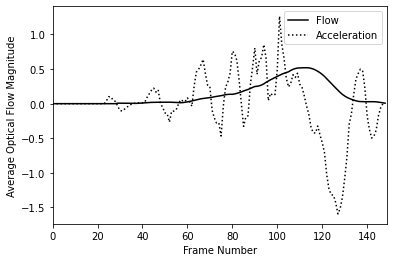

-----Running Sample: adl-02
Fall Class =  31    0
Name: fall_label, dtype: int64
Fall Prediction =  0


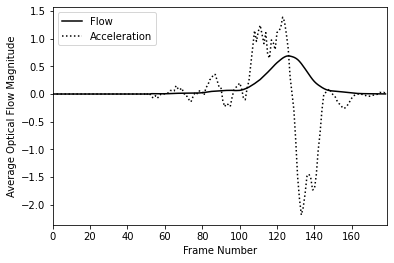

-----Running Sample: adl-03
Fall Class =  32    0
Name: fall_label, dtype: int64


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Fall Prediction =  0


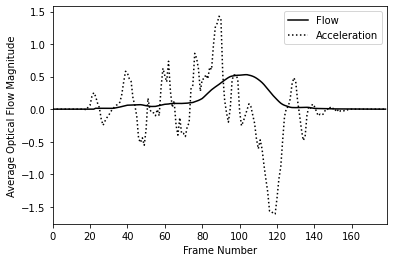

-----Running Sample: adl-04
Fall Class =  33    0
Name: fall_label, dtype: int64


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Fall Prediction =  0


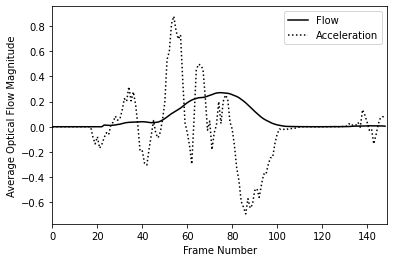

-----Running Sample: adl-05
Fall Class =  34    0
Name: fall_label, dtype: int64
Fall Prediction =  0


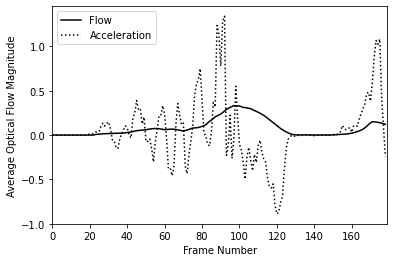

-----Running Sample: adl-06
Fall Class =  35    0
Name: fall_label, dtype: int64


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Fall Prediction =  0


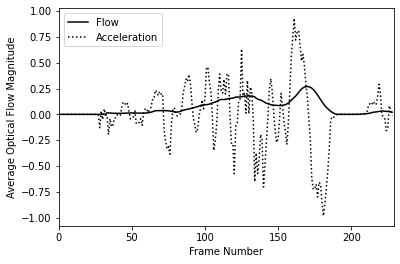

-----Running Sample: adl-07
Fall Class =  36    0
Name: fall_label, dtype: int64


In [ ]:
outMaster_fname = rootPath + 'results/output_master.csv'
saveData_fname = rootPath + 'results/sat_dec5_URFD_mvAvgAcc.csv'
outMaster = pd.read_csv(outMaster_fname)

for sampleName in urdfDataset:
  sampleID = sampleName[14:-10]
  print('-----Running Sample:', sampleID)
  print('Fall Class = ', outMaster[outMaster.sequence_name==sampleID]['fall_label'] )
  optFlow, mvAvgFlow, derivFlow, fallPred, fallStart, fallEnd = run_detector_images(sampleName,classThresh=2.5)
  print('Fall Prediction = ', fallPred)
  outMaster.loc[outMaster.sequence_name==sampleID,'fall_pred'] = fallPred
  outMaster.loc[outMaster.sequence_name==sampleID,'fall_start_pred'] = fallStart
  outMaster.loc[outMaster.sequence_name==sampleID,'fall_end_pred'] = fallEnd
  f_t = np.arange(len(mvAvgFlow))

  plt.plot(f_t,mvAvgFlow,'k',label='Flow')
  plt.plot(f_t,movAvg(derivFlow,win=5),'k:',label='Acceleration')
  plt.legend()

  plt.xlim([0,len(mvAvgFlow)])
  plt.ylabel('Average Optical Flow Magnitude')
  plt.xlabel('Frame Number')
  plt.show()
  outMaster.to_csv(saveData_fname)

#outMaster.to_csv(saveData_fname)   


